# Analyses descriptives des données "Open Food Facts"

Notre jeu de données est composée de différentes variables :

> Des variables en lien avec l'identification des produits (noms, endroits où ils sont commercialisés, date d'ajout dans la base, date de modification dans la base)

> Des variables qui mesurent la qualité des produits (nutriscore)
Des variables sur les différentes valeurs nutrionnelles du produit (graisse, graisse saturée, carbohydrates (Glucides), sucres, fibres, protéines, sel)
Des variables sur l'énergie que l'on trouve dans chaque produit (énergie en kcal)

Nous allons ensuite réaliser : 

> - une analyse univariée
> - une analyse bivariée (lien entre les variables : boxplot (Variables quantitatives Vs variables 
    qualitative) + ANOVA + régression (linéaire) entre variables quantitatives) de nos variables pour     voir leur comportement. 
> - Une ACP pour voir le % de variance expliquée et regrouper nos variables en 2 dimmensions F1, F2
> - un clustering (apprentissage non suppervisé) à travers l'algorithme K-means :
    
      > Nombre de clusters optimal (Méthode du coude)
      > Analyse des clusters : 
      > Qualité de partition : Davies_Bouldin score
      > Coefficient de silhouette "S": inertie inter-classe est elle elevée ??
      > nombre de produits dans chaque cluster
      > Caractéristiques nutritionnelles de chaque clusters (Energie, graisse,         Glucides, Protéines, graisse saturée, sucres, Sodium)

> - Test de prédiction (cluster d'appartenance d'un prduit)
      

In [748]:
# importation des librairies nécessaires
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scipy.stats as stats
import pingouin as pg    # Package Statistique
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # Missing data
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import decomposition
import math
from sklearn import metrics, cluster  # metrics permet de calculer le coefficient de silhouette

In [1]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                      plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            
def display_circles(data):
    data2  = data.filter(regex='_100g')
    data2 = StandardScaler().fit_transform(data2)
    acp =  PCA(n_components=data2.shape[1]).fit_transform(data2)
    #3D  PCA 
    n_comp = data2.shape[1]
    fig = px.scatter_3d(
        acp, x=0, y=1, z=2, color=data['nutrition_grade_fr'],
        title= "3D PCA",
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
    fig.show()
    # Explained variance
    pca = PCA()
    pca.fit(data2)
    pcs = pca.components_
    exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
    px.area(
        x=range(1, exp_var_cumul.shape[0] + 1),
        y=exp_var_cumul,
        labels={"x": "# Components", "y": "Explained Variance"}
    )
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    features = data.filter(regex='_100g').columns
    fig = px.scatter(acp, x=0, y=1, color=data['nutrition_grade_fr'])
    for i, feature in enumerate(features):
        fig.add_shape(
            type='line',
            x0=0, y0=0,
            x1=loadings[i, 0],
            y1=loadings[i, 1]
        )
        fig.add_annotation(
            x=loadings[i, 0],
            y=loadings[i, 1],
            ax=0, ay=0,
            xanchor="center",
            yanchor="bottom",
            text=feature,
        )   
    fig.show()
    #Cercle des corelations 
    display_circles(pcs, n_comp, pca, [(0,1)], labels=features)  
    

def eta_squared(x,y):
    moyenne_y=y.mean()
    classes=[]
    for classe in x.unique():
        yi_classe=y[x==classe]
        classes.append({'ni': len(yi_classe),
                       'moyenne_classe':yi_classe.mean()})
    SCT=sum([(yj-moyenne_y)**2for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT



In [750]:
filepath = 'en.openfoodfacts.org.products_clean.csv'

In [751]:
# chargement du fichier
df = pd.read_csv(filepath)
df.shape

(1936182, 28)

In [752]:
df.columns

Index(['code', 'product_name', 'packaging', 'packaging_tags', 'brands',
       'categories', 'labels', 'labels_tags', 'labels_en', 'countries',
       'additives_n', 'additives_tags', 'additives_en',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'fiber_100g', 'proteins_100g', 'sodium_100g',
       'reconstructed_energy_100g'],
      dtype='object')

# 1/ Analyses univariées
On va réaliser une analyse univariée de nos différentes variables pour voir leur comportement. On va commencer par s'intéresser aux variables catégorielles ensuite les variables quantitatives.

### a) distribution Variables qualitatives :

  > Les pays : 

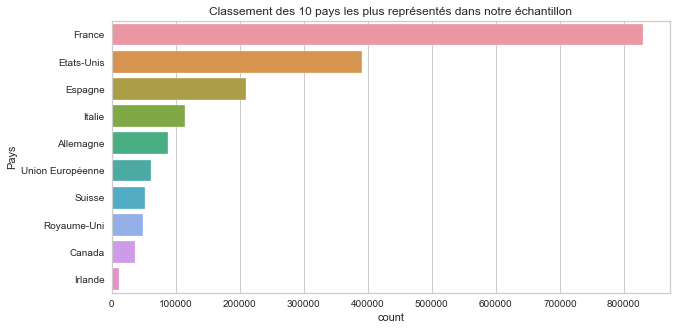

In [753]:
plt.figure(figsize=(10,5))
sns.countplot(y="countries", data=df, order=pd.value_counts(df['countries']).iloc[:10].index)
plt.ylabel("Pays")
plt.title("Classement des 10 pays les plus représentés dans notre échantillon")
plt.savefig("top_10_pays.png")
plt.show()

##### La France est le pays le plus représenté dans notre échantillon. Pour la suite de l'analyse, elle se fera uniquement pour la France

In [754]:
df_France = df.loc[df['countries'] == 'France']
df_France.shape

(829942, 28)

 > Les marques :

In [755]:
print('Nombre de marques :', len(df_France['brands'].unique()))

Nombre de marques : 80975


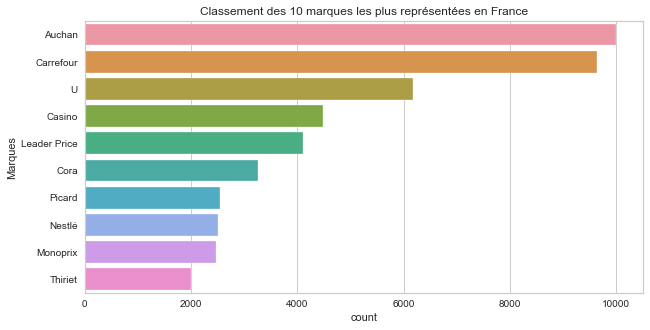

In [756]:
plt.figure(figsize=(10, 5))
sns.countplot(y="brands", data=df_France, order=pd.value_counts(df_France['brands']).iloc[:10].index)
plt.ylabel("Marques")
plt.title("Classement des 10 marques les plus représentées en France")
plt.savefig("top_10_marques.png")
plt.show()

 > Types de produits :

In [757]:
print('Nombre de produits :', len(df_France['product_name']))

Nombre de produits : 829942


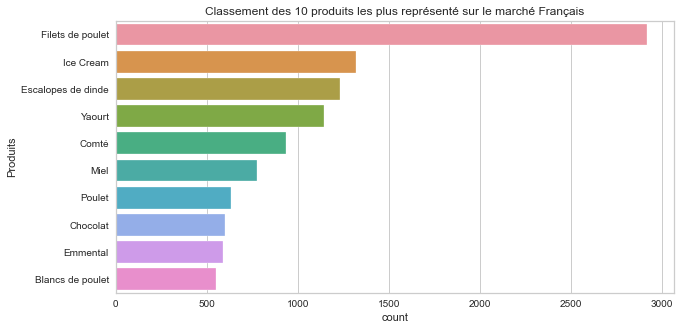

In [758]:
plt.figure(figsize=(10, 5))
sns.countplot(y="product_name", data=df_France, order=pd.value_counts(df_France['product_name']).iloc[:10].index)
plt.ylabel("Produits")
plt.title("Classement des 10 produits les plus représenté sur le marché Français")
plt.savefig("top_10_produits.png")
plt.show()

In [759]:
df_France['nutriscore_grade'] = df_France['nutriscore_grade'].replace("a", "A")
df_France['nutriscore_grade'] = df_France['nutriscore_grade'].replace("b", "B")
df_France['nutriscore_grade'] = df_France['nutriscore_grade'].replace("c", "C")
df_France['nutriscore_grade'] = df_France['nutriscore_grade'].replace("d", "D")
df_France['nutriscore_grade'] = df_France['nutriscore_grade'].replace("e", "E")

### b) Distribution Variables catégorielles : 

In [760]:
df_France["ingerients_palm_oil"] = df_France["ingredients_from_palm_oil_n"] + df_France["ingredients_that_may_be_from_palm_oil_n"]

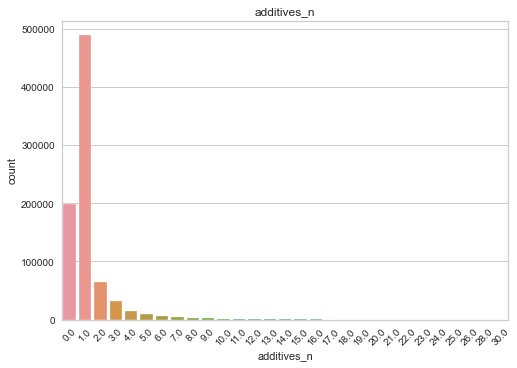

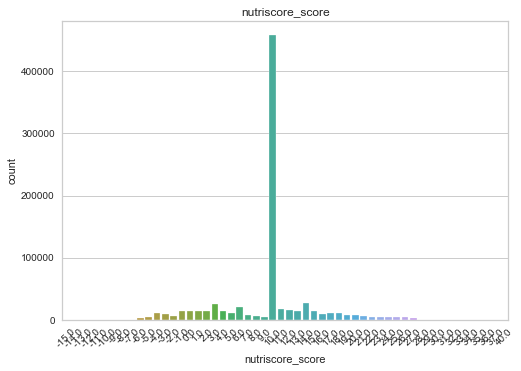

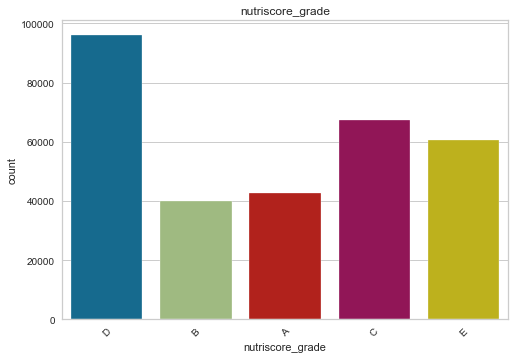

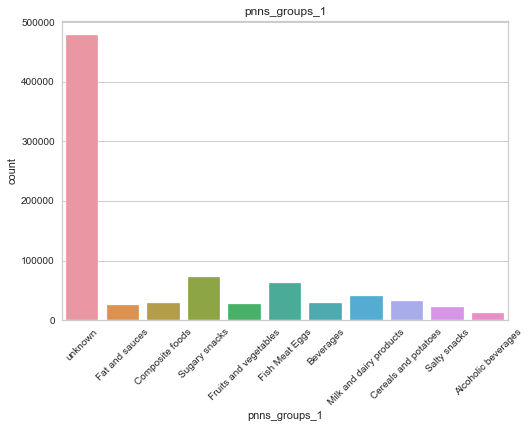

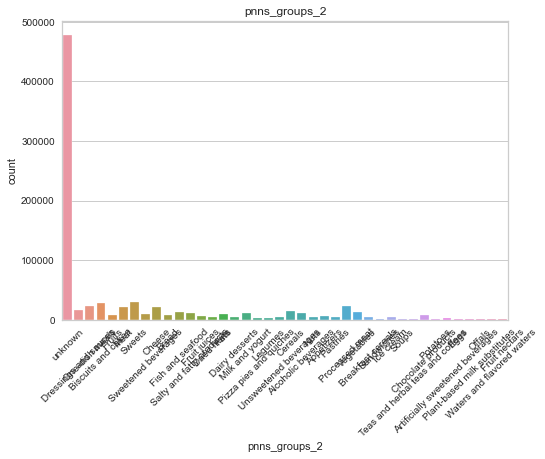

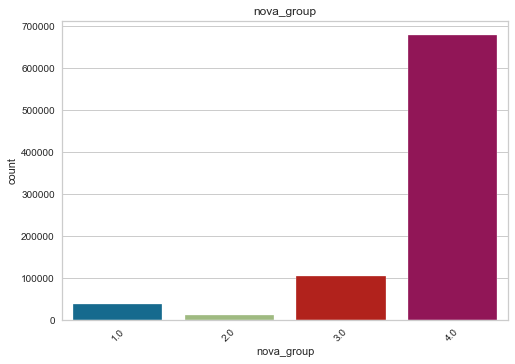

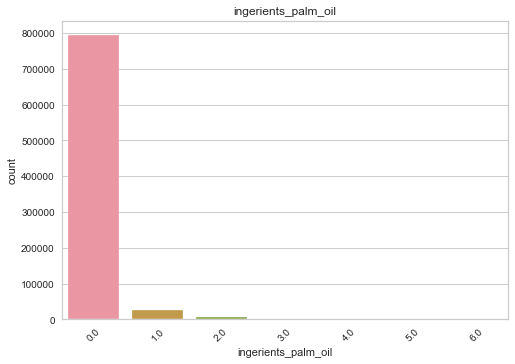

In [761]:
col_cat = ["additives_n", "nutriscore_score", "nutriscore_grade", "pnns_groups_1", "pnns_groups_2", "nova_group","ingerients_palm_oil"]

for col in col_cat:
    sns.countplot(x=col, data=df_France)
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

La majoritée des produits ne contiennent pas d'huile de palm

La majoritée des produits sont ultra-transformés (NOVA-GROUP = 4)

La majorité des produits contient 1 additif

Le nutri-score "D" est majoritaire

### c) Distribution des variables quantitatives :  

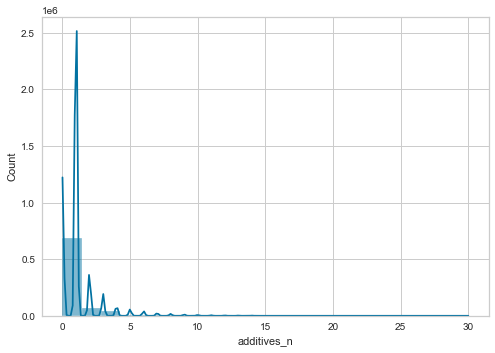

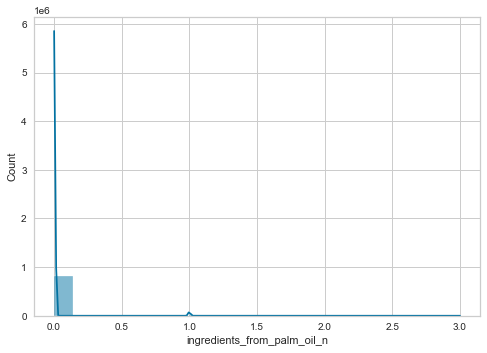

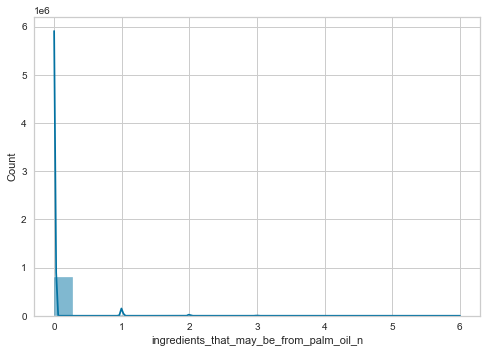

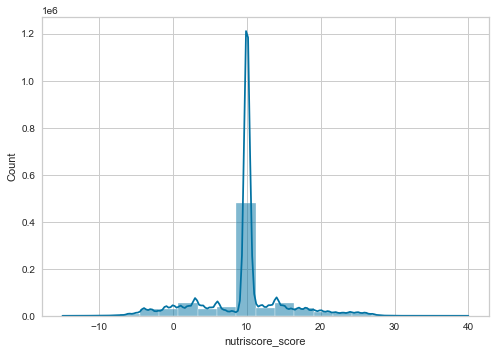

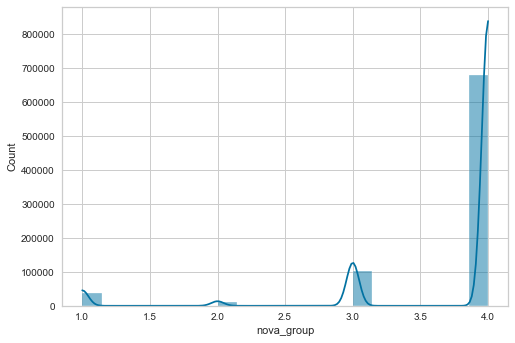

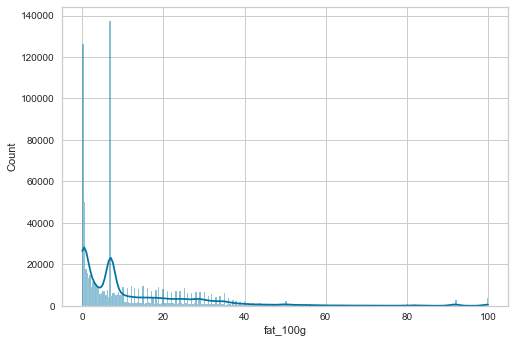

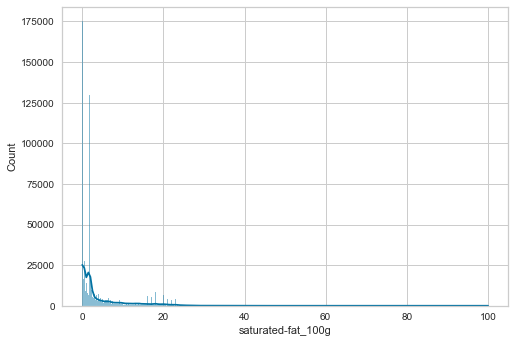

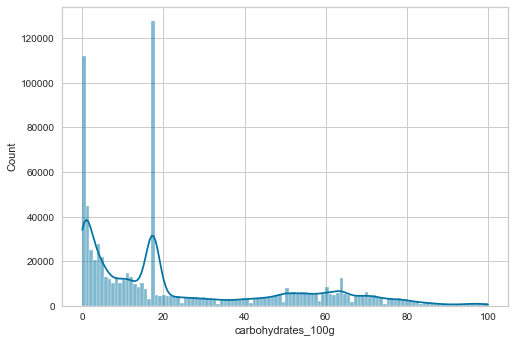

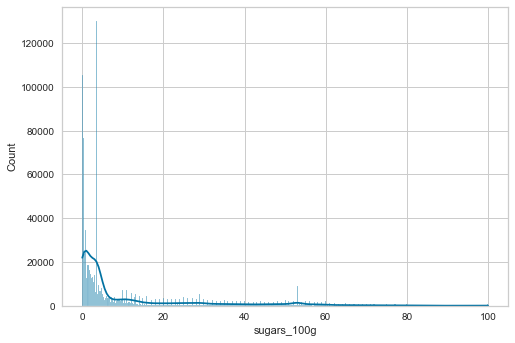

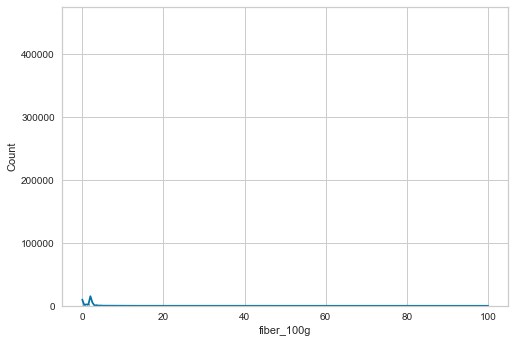

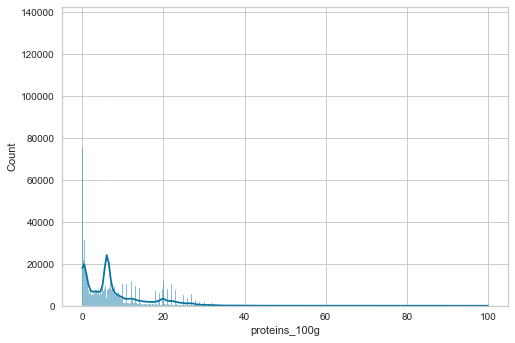

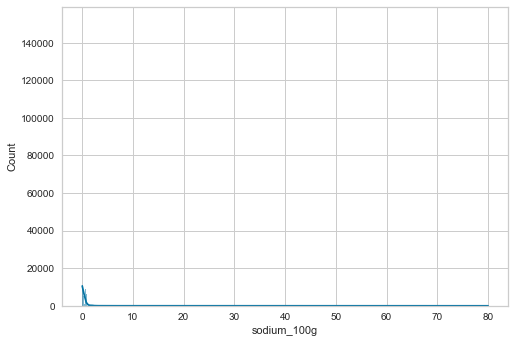

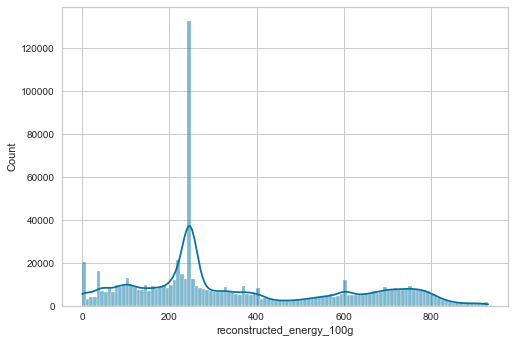

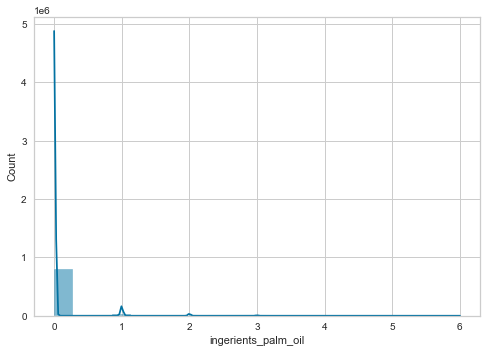

In [762]:
for var in df_France.columns:
    if df_France[var].dtypes == 'float64':
        sns.histplot(x=var, data=df_France, kde=True)
        plt.show()

Les variables semblent ne pas suivre une distribution normale

Test de normalité de notre échantillon (Test de Shapiro-Wilk car il a une meilleure puissance pour un niveau de signifiance donné)

In [763]:
pg.normality(df_France, method='shapiro', alpha=0.05)

,W,pval,normal
additives_n,0.583246,0.0,False
ingredients_from_palm_oil_n,0.094103,0.0,False
ingredients_that_may_be_from_palm_oil_n,0.155119,0.0,False
nutriscore_score,0.868559,0.0,False
nova_group,0.441116,0.0,False
fat_100g,0.735220,0.0,False
saturated-fat_100g,0.644571,0.0,False
carbohydrates_100g,0.847678,0.0,False
sugars_100g,0.668609,0.0,False
fiber_100g,0.436234,0.0,False


P-value < 0.05 => l'ypothèse nulle H0 : "la distribution suit une loi normale" est rejetée. 

Test d'homogénéité des variances

> Le choix s'est porté sur un test de Levene car il est plus efficace lorsque les distributions ne suivent pas une loi normale

In [764]:
pg.homoscedasticity(df_France, method='levene', alpha=0.05)

,W,pval,equal_var
levene,873905.266789,0.0,False


# Conclusion : 
Aucune variable ne suit une loi normale. Les variances de nos variables ne sont pas homogènes. 

### d) Comportement des variables :

#### Graphique : 

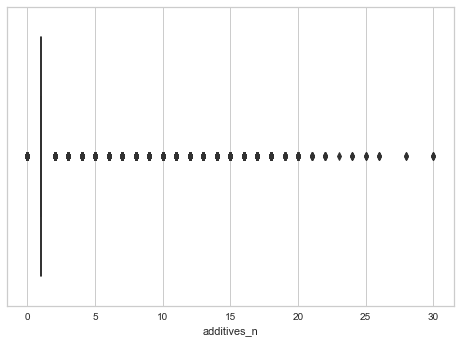

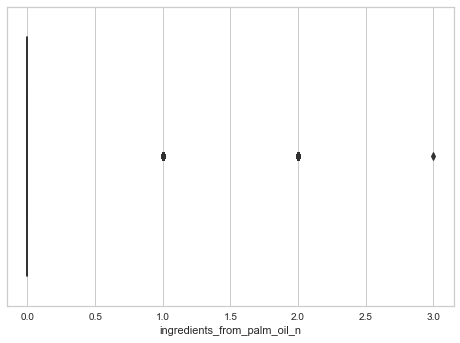

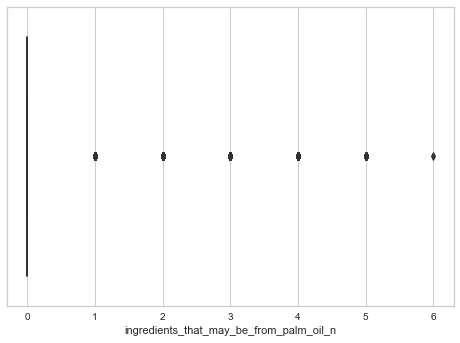

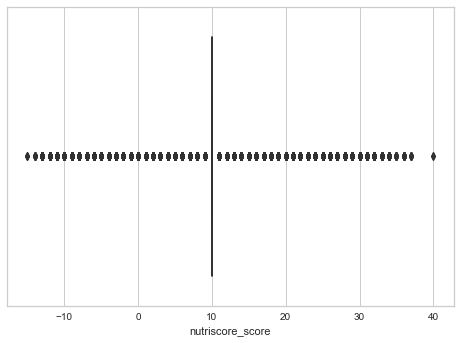

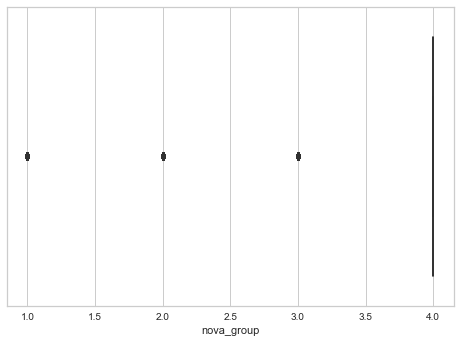

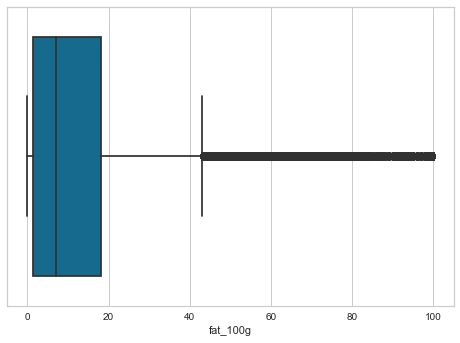

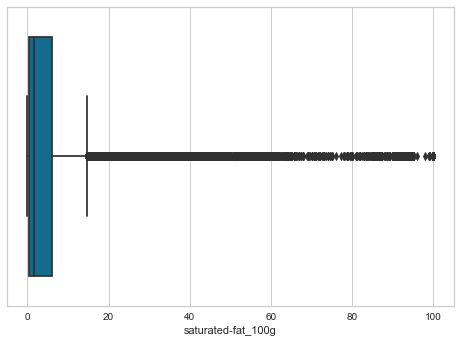

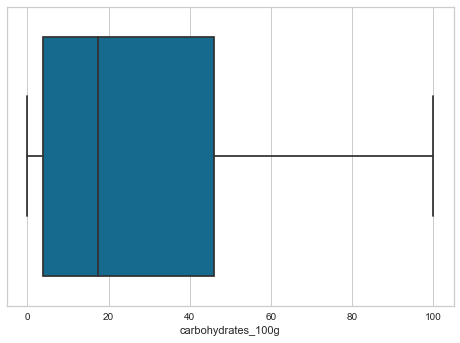

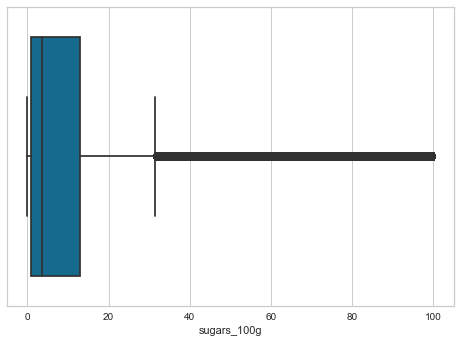

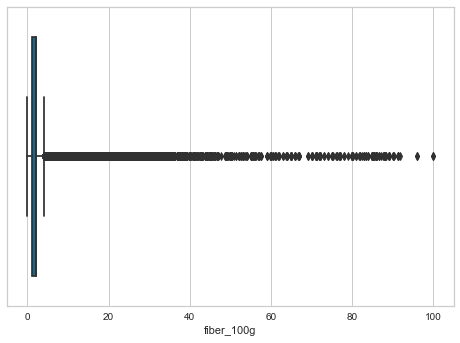

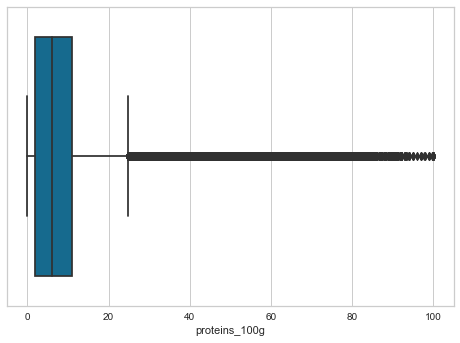

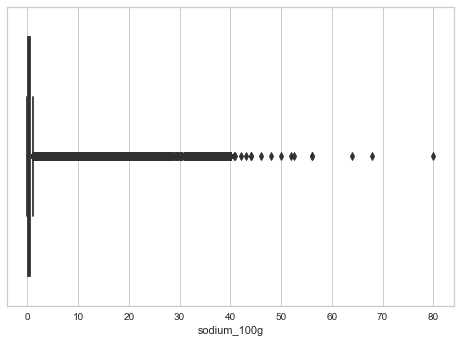

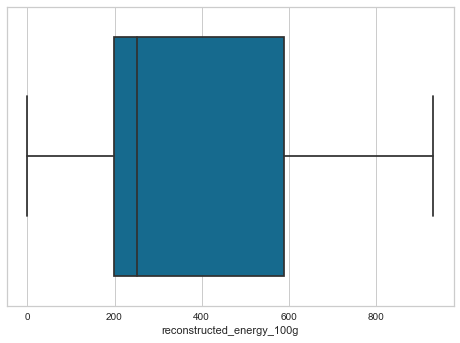

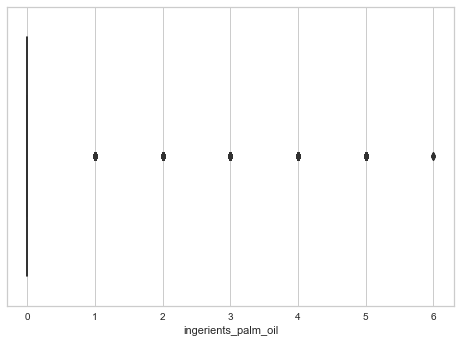

In [765]:
for var in df_France.columns:
    if (df_France[var].dtypes == 'float64'):
        sns.boxplot(x=var, data=df_France)
        plt.show()

#### Statistique : 

In [766]:
df_France.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nova_group,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,reconstructed_energy_100g,ingerients_palm_oil
count,829942.000000,829942.000000,829942.000000,829942.000000,829942.000000,829942.000000,829942.000000,829942.000000,829942.000000,829942.000000,829942.000000,829942.000000,829942.000000,829942.000000
mean,1.170960,0.014584,0.039182,9.563067,3.716197,12.616526,4.654682,25.006869,11.931686,2.040648,8.306660,0.434156,361.538618,0.053766
std,1.422279,0.121607,0.236715,5.703572,0.704882,16.088063,7.237711,25.576551,18.582872,2.412454,9.075503,1.516254,242.987468,0.283707
min,0.000000,0.000000,0.000000,-15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,10.000000,4.000000,1.400000,0.300000,3.900000,0.800000,1.000000,1.900000,0.040000,197.645000,0.000000
50%,1.000000,0.000000,0.000000,10.000000,4.000000,7.000000,1.700000,17.400000,3.570000,2.200000,6.100000,0.232000,251.260000,0.000000
75%,1.000000,0.000000,0.000000,10.000000,4.000000,18.000000,6.000000,46.000000,13.000000,2.200000,11.000000,0.440000,589.662500,0.000000
max,30.000000,3.000000,6.000000,40.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,80.000000,931.500000,6.000000


# 2/ Analyses Bivariées

####  > Matrice de corelation : 
Corrélation entre les variables 

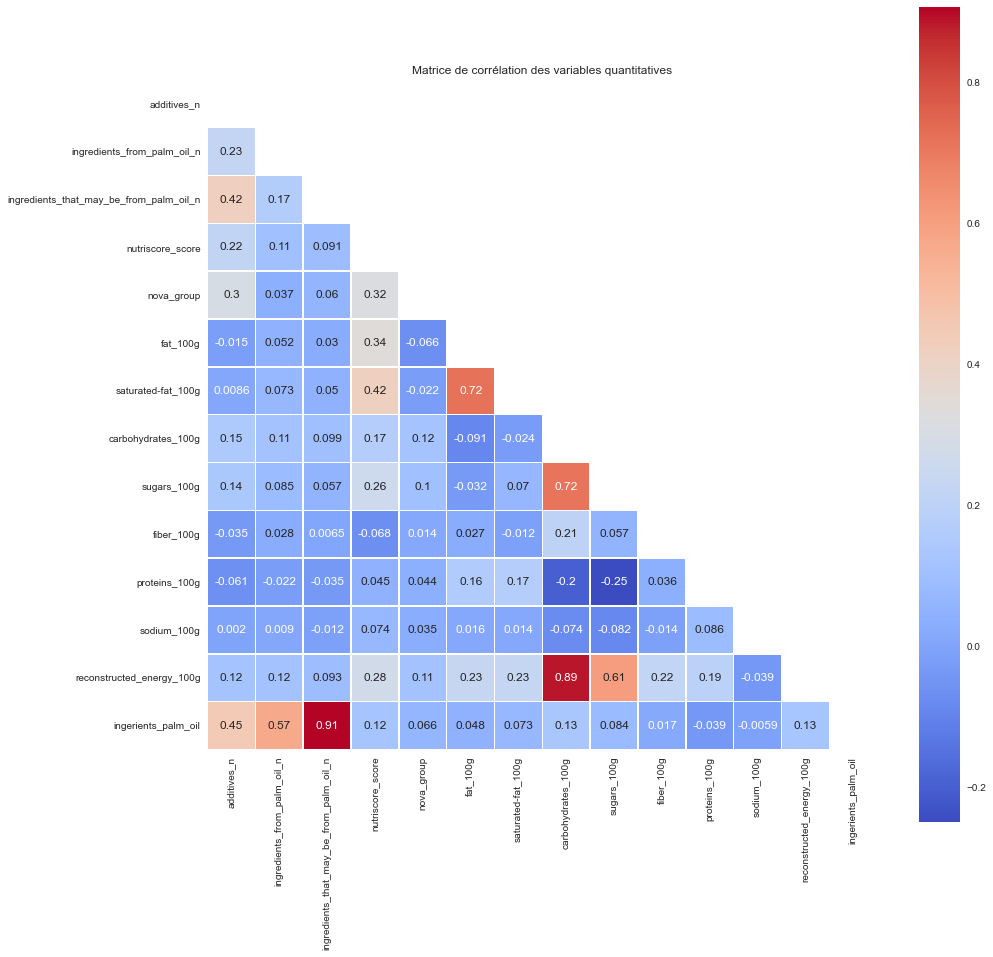

In [767]:
corr_matrix = df_France.corr()
mask = np.triu(corr_matrix)
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap="coolwarm", mask=mask, linewidths=.5, annot=True, cbar=True, square=True)
plt.title("Matrice de corrélation des variables quantitatives")
plt.savefig("matrice_corr.png")
plt.show()

Il y a  une forte corrélation entre l'énergie et : les Glucides, le sucre 

### a) Variables quantitatives :  

####  > Analyse de regression :
 > . Energy Kcal pour 100g  <-> Les autres quantités pour 100g 

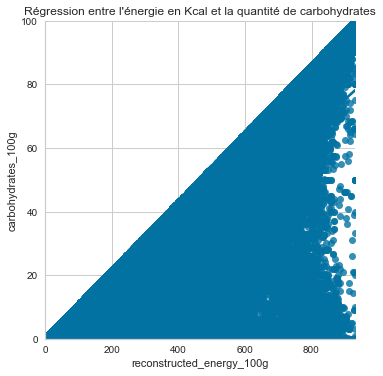

Coefficient de corrélation linéaire =  0.8865062632630052
Covariance =  5509.43599483601


In [768]:
sns.lmplot(x="reconstructed_energy_100g", y="carbohydrates_100g", data=df_France)
plt.title("Régression entre l'énergie en Kcal et la quantité de carbohydrates")
plt.xlim(df_France["reconstructed_energy_100g"].min(), df_France["reconstructed_energy_100g"].max())
plt.ylim(df_France["carbohydrates_100g"].min(), df_France["carbohydrates_100g"].max())
plt.show()
print('Coefficient de corrélation linéaire = ',stats.pearsonr(df_France["reconstructed_energy_100g"],df_France["carbohydrates_100g"])[0])
print('Covariance = ',np.cov(df_France["reconstructed_energy_100g"],df_France["carbohydrates_100g"],ddof=0)[1][0])

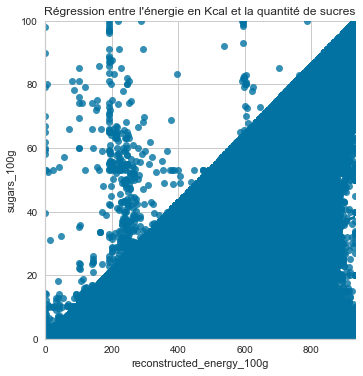

Coefficient de corrélation linéaire =  0.606136121090251
Covariance =  2736.9467462496013


In [769]:
sns.lmplot(x="reconstructed_energy_100g", y="sugars_100g", data=df_France)
plt.title("Régression entre l'énergie en Kcal et la quantité de sucres")
plt.xlim(df_France["reconstructed_energy_100g"].min(), df_France["reconstructed_energy_100g"].max())
plt.ylim(df_France["sugars_100g"].min(), df_France["sugars_100g"].max())
plt.show()
print('Coefficient de corrélation linéaire = ',stats.pearsonr(df_France["reconstructed_energy_100g"],df_France["sugars_100g"])[0])
print('Covariance = ',np.cov(df_France["reconstructed_energy_100g"],df_France["sugars_100g"],ddof=0)[1][0])

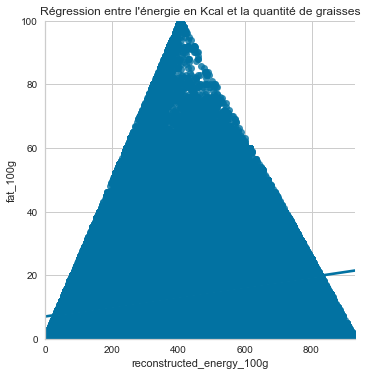

Coefficient de corrélation linéaire =  0.2345747074527912
Covariance =  916.997806866809


In [770]:
sns.lmplot(x="reconstructed_energy_100g", y="fat_100g", data=df_France)
plt.title("Régression entre l'énergie en Kcal et la quantité de graisses")
plt.xlim(df_France["reconstructed_energy_100g"].min(), df_France["reconstructed_energy_100g"].max())
plt.ylim(df_France["fat_100g"].min(), df_France["fat_100g"].max())
plt.show()
print('Coefficient de corrélation linéaire = ',stats.pearsonr(df_France["reconstructed_energy_100g"],df_France["fat_100g"])[0])
print('Covariance = ',np.cov(df_France["reconstructed_energy_100g"],df_France["fat_100g"],ddof=0)[1][0])

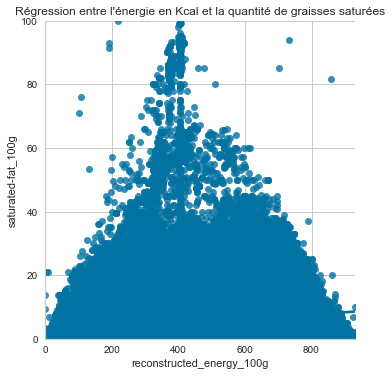

Coefficient de corrélation linéaire =  0.22984531888771104
Covariance =  404.22227667888467


In [771]:
sns.lmplot(x="reconstructed_energy_100g", y="saturated-fat_100g", data=df_France)
plt.title("Régression entre l'énergie en Kcal et la quantité de graisses saturées")
plt.xlim(df_France["reconstructed_energy_100g"].min(), df_France["reconstructed_energy_100g"].max())
plt.ylim(df_France["saturated-fat_100g"].min(), df_France["saturated-fat_100g"].max())
plt.show()
print('Coefficient de corrélation linéaire = ',stats.pearsonr(df_France["reconstructed_energy_100g"],df_France["saturated-fat_100g"])[0])
print('Covariance = ',np.cov(df_France["reconstructed_energy_100g"],df_France["saturated-fat_100g"],ddof=0)[1][0])

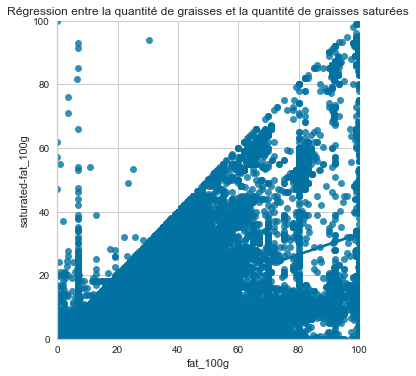

Coefficient de corrélation linéaire =  0.7202506536530796
Covariance =  83.86642408334781


In [772]:
sns.lmplot(x="fat_100g", y="saturated-fat_100g", data=df_France)
plt.title("Régression entre la quantité de graisses et la quantité de graisses saturées")
plt.xlim(df_France["fat_100g"].min(), df_France["fat_100g"].max())
plt.ylim(df_France["saturated-fat_100g"].min(), df_France["saturated-fat_100g"].max())
plt.show()
print('Coefficient de corrélation linéaire = ',stats.pearsonr(df_France["fat_100g"],df_France["saturated-fat_100g"])[0])
print('Covariance = ',np.cov(df_France["fat_100g"],df_France["saturated-fat_100g"],ddof=0)[1][0])

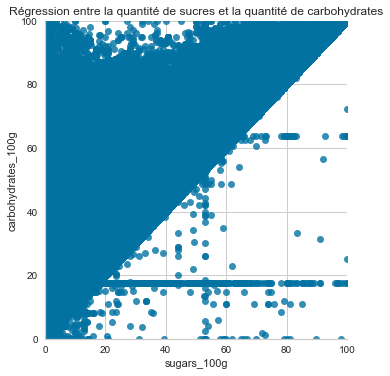

Coefficient de corrélation linéaire =  0.8865062632630052
Covariance =  5509.43599483601


In [773]:
sns.lmplot(x="sugars_100g", y="carbohydrates_100g", data=df_France)
plt.title("Régression entre la quantité de sucres et la quantité de carbohydrates")
plt.xlim(df_France["sugars_100g"].min(), df_France["sugars_100g"].max())
plt.ylim(df_France["carbohydrates_100g"].min(), df_France["carbohydrates_100g"].max())
plt.show()
print('Coefficient de corrélation linéaire = ',stats.pearsonr(df_France["reconstructed_energy_100g"],df_France["carbohydrates_100g"])[0])
print('Covariance = ',np.cov(df_France["reconstructed_energy_100g"],df_France["carbohydrates_100g"],ddof=0)[1][0])

### b) Variables qualitatives et quantitatives :

> Quantité de sucre et les différentes variables qualitatives

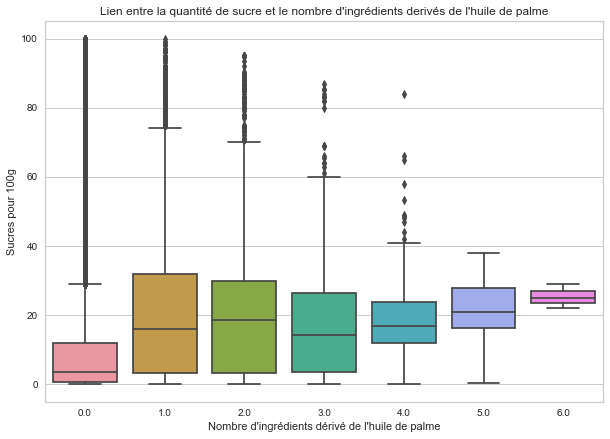

In [774]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingerients_palm_oil", y="sugars_100g", data=df_France)
plt.title("Lien entre la quantité de sucre et le nombre d'ingrédients derivés de l'huile de palme")
plt.xlabel("Nombre d'ingrédients dérivé de l'huile de palme")
plt.ylabel("Sucres pour 100g")
plt.show()

In [775]:
pg.anova(data=df_France, dv="sugars_100g", between="ingerients_palm_oil")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingerients_palm_oil,6,829935,1271.761563,0.0,0.00911


In [776]:
eta_squared(df_France["ingerients_palm_oil"],df_France["sugars_100g"])

0.009110414341301847

#### Le nombre d'ingrédients dérivés de l'huile de palm n'a pas d'effet significatif sur le taux de sucre

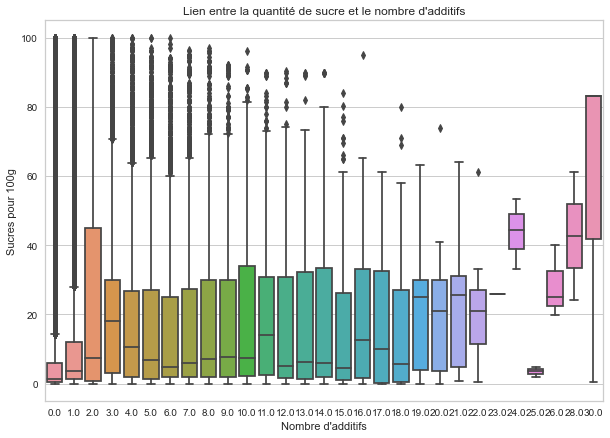

In [777]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="additives_n", y="sugars_100g", data=df_France)
plt.title("Lien entre la quantité de sucre et le nombre d'additifs")
plt.xlabel("Nombre d'additifs")
plt.ylabel("Sucres pour 100g")
plt.show()

In [778]:
pg.anova(data=df_France, dv="sugars_100g", between="additives_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,additives_n,28,829913,1329.414765,0.0,0.042927


In [779]:
eta_squared(df_France["additives_n"],df_France["sugars_100g"])

0.04292704615424504

##### eta_squared (np2) proche de zéro => Effet modéré du nombre d'additifs sur le taux de sucre

> Protéines et les différentes variables qualitatives

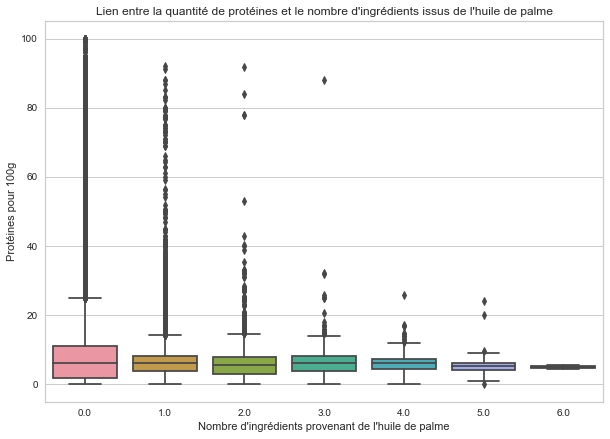

In [780]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingerients_palm_oil", y="proteins_100g", data=df_France)
plt.xlabel("Nombre d'ingrédients provenant de l'huile de palme")
plt.ylabel("Protéines pour 100g")
plt.title("Lien entre la quantité de protéines et le nombre d'ingrédients issus de l'huile de palme")
plt.savefig("palm_oil_vs_proteins.png")
plt.show()

In [781]:
pg.anova(data=df_France, dv="proteins_100g", between="ingerients_palm_oil")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingerients_palm_oil,6,829935,231.275578,2.031336e-296,0.001669


In [782]:
eta_squared(df_France["ingerients_palm_oil"],df_France["proteins_100g"])

0.0016692116617242527

##### eta_squared (np2) proche de zéro => Faible corrélation entre les protéines et l'huile de palm

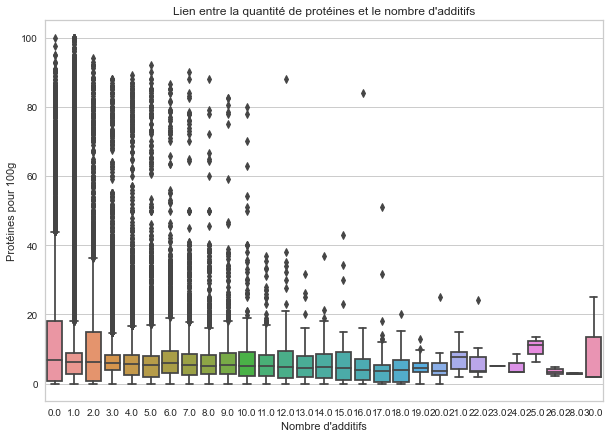

In [783]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="additives_n", y="proteins_100g", data=df_France)
plt.xlabel("Nombre d'additifs")
plt.ylabel("Protéines pour 100g")
plt.title("Lien entre la quantité de protéines et le nombre d'additifs")
plt.savefig("additifs_vs_proteins.png")
plt.show()

In [784]:
pg.anova(data=df_France, dv="proteins_100g", between="additives_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,additives_n,28,829913,264.59158,0.0,0.008848


In [785]:
eta_squared(df_France["additives_n"],df_France["proteins_100g"])

0.008847931964949577

##### eta_squared (np2) proche de zéro => Faible corrélation entre les protéines et le nombre d'additifs

> Graisse et les différentes variables qualitatives

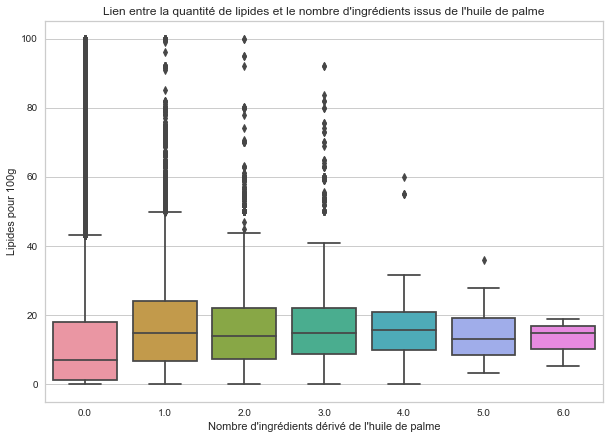

In [786]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingerients_palm_oil", y="fat_100g", data=df_France)
plt.xlabel("Nombre d'ingrédients dérivé de l'huile de palme")
plt.ylabel("Lipides pour 100g")
plt.title("Lien entre la quantité de lipides et le nombre d'ingrédients issus de l'huile de palme")
plt.savefig("huile_de_palm_vs_graisses.png")
plt.show()

In [787]:
pg.anova(data=df_France, dv="fat_100g", between="ingerients_palm_oil")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingerients_palm_oil,6,829935,389.993711,0.0,0.002812


In [788]:
eta_squared(df_France["ingerients_palm_oil"],df_France["fat_100g"])

0.002811525485012914

##### eta_squared (np2) proche de zéro => Faible corrélation entre la graisse et l'huile de palm

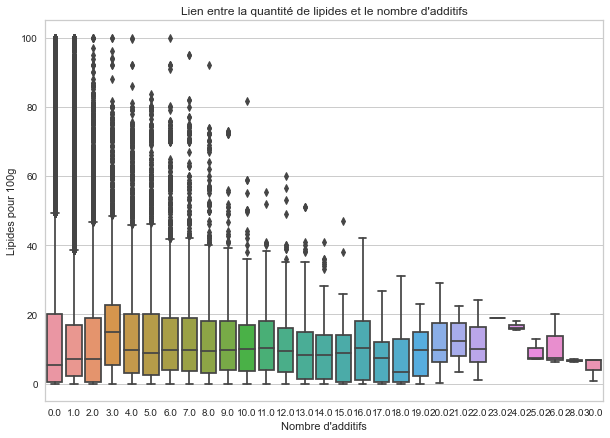

In [789]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="additives_n", y="fat_100g", data=df_France)
plt.xlabel("Nombre d'additifs")
plt.ylabel("Lipides pour 100g")
plt.title("Lien entre la quantité de lipides et le nombre d'additifs")
plt.savefig("additifs_vs_lipides.png")
plt.show()

In [790]:
pg.anova(data=df_France, dv="fat_100g", between="additives_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,additives_n,28,829913,131.529295,0.0,0.004418


In [791]:
eta_squared(df_France["additives_n"],df_France["fat_100g"])

0.004417992727322436

##### eta_squared (np2) proche de zéro => Faible corrélation entre la graisse et le nombre d'additifs

 > Glucides et les différentes variables quanlitatives

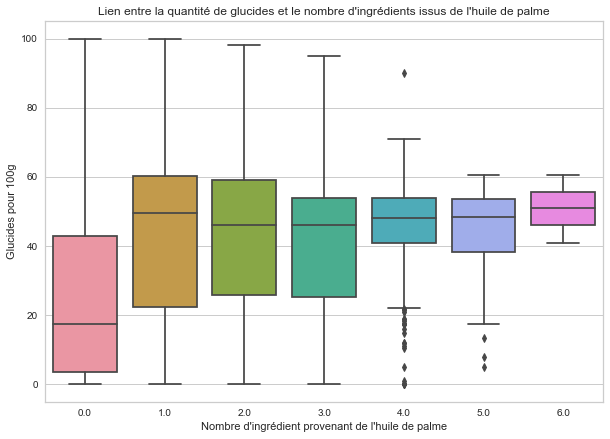

In [792]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingerients_palm_oil", y="carbohydrates_100g", data=df_France)
plt.title("Lien entre la quantité de glucides et le nombre d'ingrédients issus de l'huile de palme")
plt.xlabel("Nombre d'ingrédient provenant de l'huile de palme")
plt.ylabel("Glucides pour 100g")
plt.savefig("carbohydrates_vs_palm_oil.png")
plt.show()

In [793]:
pg.anova(data=df_France, dv="carbohydrates_100g", between="ingerients_palm_oil")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingerients_palm_oil,6,829935,2975.206037,0.0,0.021056


In [794]:
eta_squared(df_France["ingerients_palm_oil"],df_France["carbohydrates_100g"])

0.0210562939832128

##### eta_squared (np2) proche de zéro => Faible corrélation entre les glucides et l'hile de palm

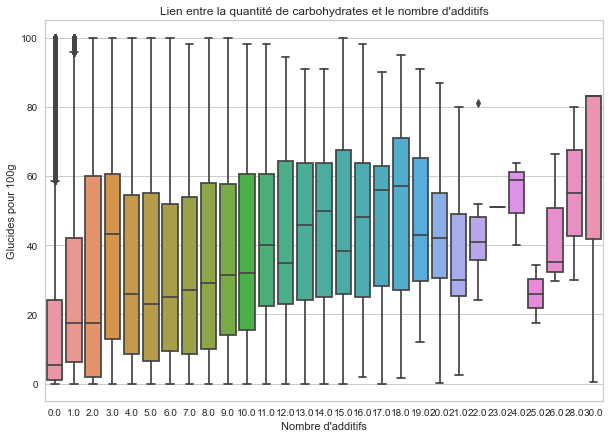

In [795]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="additives_n", y="carbohydrates_100g", data=df_France)
plt.title("Lien entre la quantité de carbohydrates et le nombre d'additifs")
plt.xlabel("Nombre d'additifs")
plt.ylabel("Glucides pour 100g")
plt.savefig("carbohydrates_vs_additifs.png")
plt.show()

In [796]:
pg.anova(data=df_France, dv="carbohydrates_100g", between="additives_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,additives_n,28,829913,1066.340947,0.0,0.034727


In [797]:
eta_squared(df_France["additives_n"],df_France["carbohydrates_100g"])

0.034727342810145105

##### eta_squared (np2) proche de zéro => Faible corrélation entre les glucides et les additifs

 > Sel et les différentes variables qualitatives

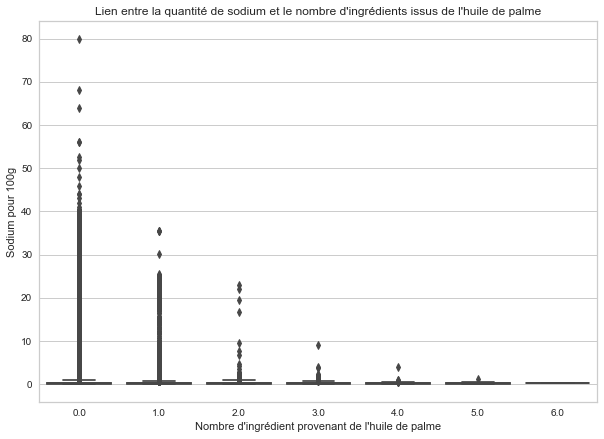

In [798]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingerients_palm_oil", y="sodium_100g", data=df_France)
plt.title("Lien entre la quantité de sodium et le nombre d'ingrédients issus de l'huile de palme")
plt.xlabel("Nombre d'ingrédient provenant de l'huile de palme")
plt.ylabel("Sodium pour 100g")
plt.show()

In [799]:
pg.anova(data=df_France, dv="sodium_100g", between="ingerients_palm_oil")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingerients_palm_oil,6,829935,8.077866,9.535688e-09,0.000058


In [800]:
eta_squared(df_France["ingerients_palm_oil"],df_France["sodium_100g"])

5.839537288568358e-05

##### eta_squared (np2) proche de zéro => Faible corrélation entre le sel  et l'huile de palm

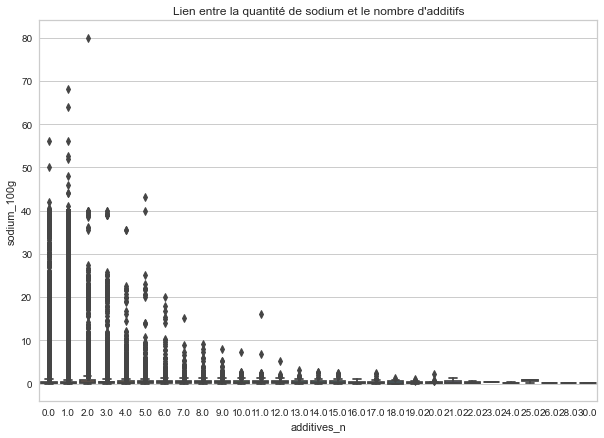

In [801]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="additives_n", y="sodium_100g", data=df_France)
plt.title("Lien entre la quantité de sodium et le nombre d'additifs")
plt.show()

In [802]:
pg.anova(data=df_France, dv="sodium_100g", between="additives_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,additives_n,28,829913,21.474948,8.177015e-109,0.000724


In [803]:
eta_squared(df_France["additives_n"],df_France["sodium_100g"])

0.000724007459557965

##### eta_squared (np2) proche de zéro => Faible corrélation entre le sel  et les additifs

 > Energie et les différentes variables qualitatives

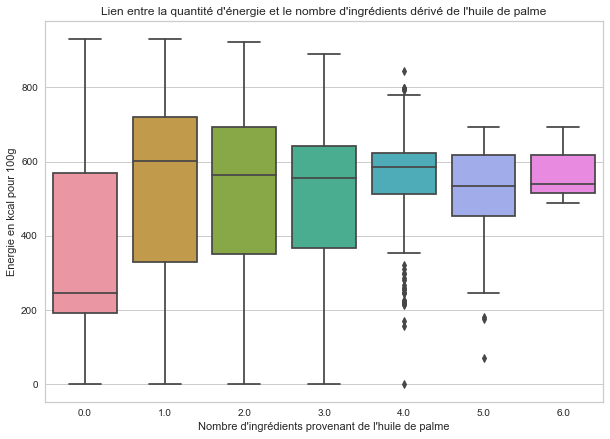

In [804]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="ingerients_palm_oil", y="reconstructed_energy_100g", data=df_France)
plt.title("Lien entre la quantité d'énergie et le nombre d'ingrédients dérivé de l'huile de palme")
plt.xlabel("Nombre d'ingrédients provenant de l'huile de palme")
plt.ylabel("Energie en kcal pour 100g")
plt.savefig("energy-kcal_vs_palm_oil.png")
plt.show()

In [805]:
pg.anova(data=df_France, dv="reconstructed_energy_100g", between="ingerients_palm_oil")

,Source,ddof1,ddof2,F,p-unc,np2
0,ingerients_palm_oil,6,829935,2870.479492,0.0,0.02033


In [806]:
eta_squared(df_France["ingerients_palm_oil"],df_France["reconstructed_energy_100g"])

0.020330185697683092

##### eta_squared (np2) proche de zéro => Faible corrélation entre l'energie et les ingrédient issu de l'huile de palm

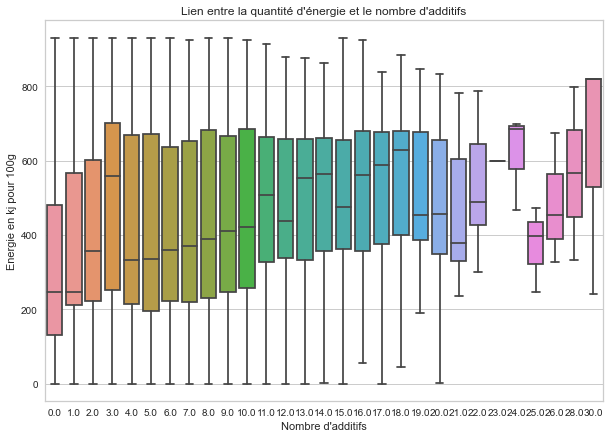

In [807]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="additives_n", y="reconstructed_energy_100g", data=df_France)
plt.title("Lien entre la quantité d'énergie et le nombre d'additifs")
plt.xlabel("Nombre d'additifs")
plt.ylabel("Energie en kj pour 100g")
plt.savefig("energy-kcal_vs_additives.png")
plt.show()

In [808]:
pg.anova(data=df_France, dv="reconstructed_energy_100g", between="additives_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,additives_n,28,829913,743.572373,0.0,0.024473


In [809]:
eta_squared(df_France["additives_n"],df_France["reconstructed_energy_100g"])

0.024473043600583486

##### eta_squared (np2) proche de zéro => Faible corrélation entre l'energie et les additifs

### C) Entre variables qualitatives :
Test du Chi2

Nombre d'ingrédients issus de l'huile de palme et nombre d'additifs

In [810]:
expected, observed, stats = pg.chi2_independence(data=df_France, x="ingerients_palm_oil", y="additives_n")
stats.round(3)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,278269.267,168.0,0.0,0.236,1.0
1,cressie-read,0.667,148840.374,168.0,0.0,0.173,1.0
2,log-likelihood,0.000,90023.288,168.0,0.0,0.134,1.0
3,freeman-tukey,-0.500,NaN,168.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.000,inf,168.0,0.0,inf,1.0
5,neyman,-2.000,NaN,168.0,NaN,NaN,NaN


In [811]:
contingency = pd.crosstab(index=df_France["ingerients_palm_oil"], columns=df_France["additives_n"], margins=True)

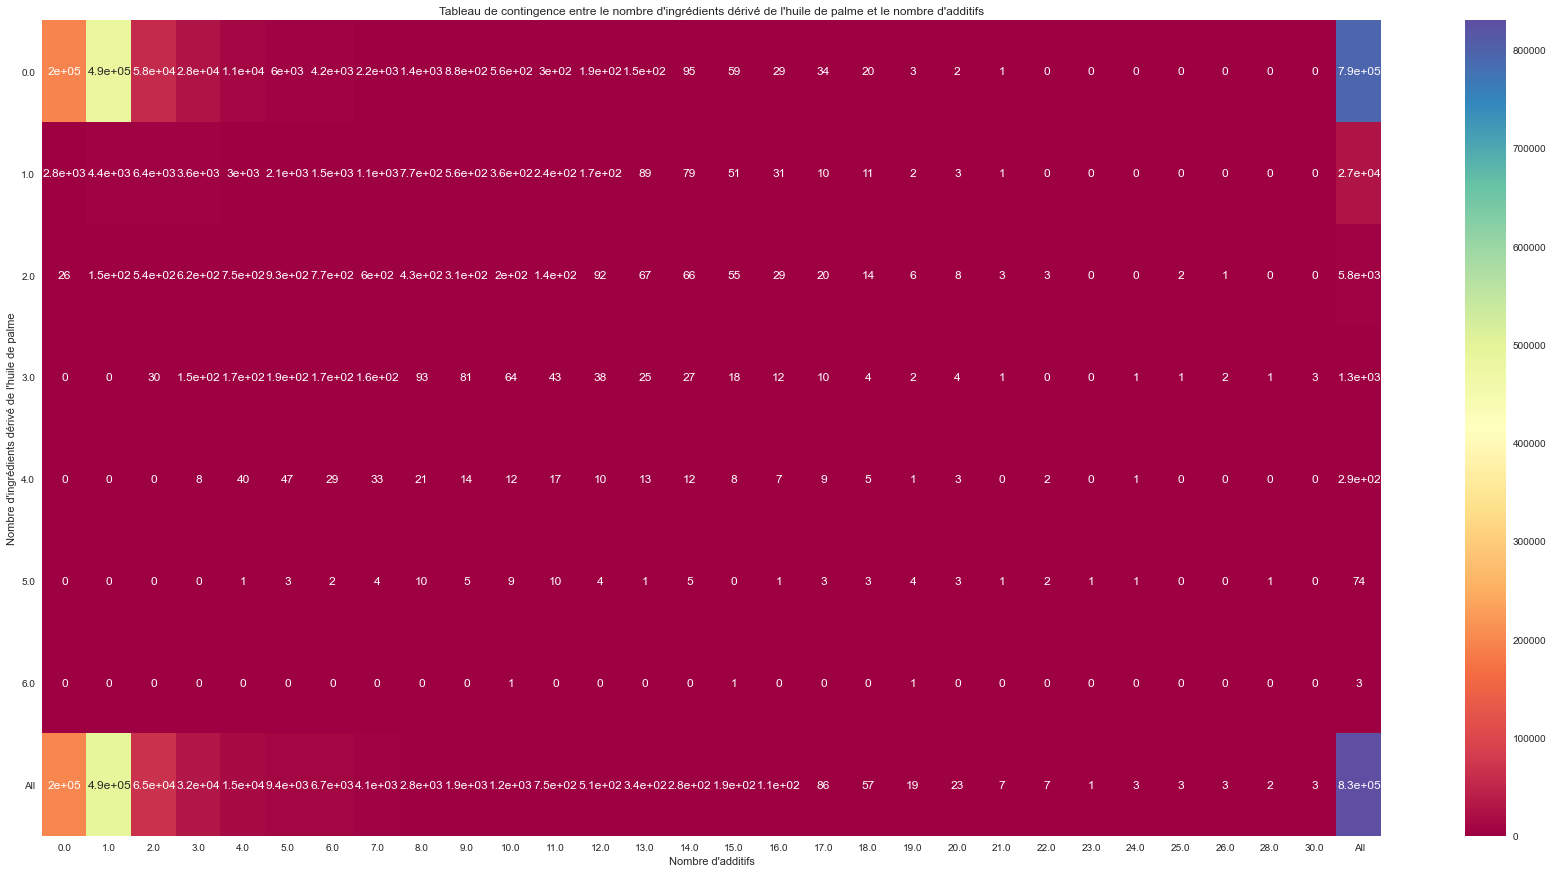

In [812]:
plt.figure(figsize=(30,15))
sns.heatmap(contingency, annot=True, cmap="Spectral")
plt.xlabel("Nombre d'additifs")
plt.ylabel("Nombre d'ingrédients dérivé de l'huile de palme")
plt.yticks(rotation=360)
plt.title("Tableau de contingence entre le nombre d'ingrédients dérivé de l'huile de palme et le nombre d'additifs")
plt.savefig("Contingency_tab.png")
plt.show()

# 3) ACP
Voyons voir si on peut regrouper nos variables en 2 composantes maximum (F1) et (F2) et maximisant la variance selon ces deux axes

In [1124]:
df_France=df_France.drop(['additives_tags','additives_en','packaging','packaging_tags','brands','categories','labels','labels_tags','labels_en'], axis=1)

KeyError: "['additives_tags' 'additives_en' 'packaging' 'packaging_tags' 'brands'\n 'categories' 'labels' 'labels_tags' 'labels_en'] not found in axis"

In [1125]:
df_France.tail(50)

,code,product_name,countries,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,reconstructed_energy_100g,ingerients_palm_oil,Clusters
1936112,99991111,Trio de lentilles & saumon fumé,France,1.0,0.0,0.0,10.0,NaN,4.0,unknown,...,11.00,2.60,11.00,1.100,2.20,9.00,0.392,230.96000,0.0,0
1936113,9999200847366,Choco pearls,France,2.0,0.0,0.0,10.0,NaN,4.0,unknown,...,27.00,16.00,61.00,50.000,0.00,7.00,0.096,743.04000,0.0,1
1936116,99993306,Pizza thon cuite sur pierre,France,3.0,0.0,0.0,11.0,D,4.0,Composite foods,...,9.80,3.50,23.80,5.500,1.60,10.00,0.492,354.63500,0.0,0
1936117,9999406003160,Crosti'miel vrac,France,1.0,0.0,0.0,10.0,NaN,4.0,unknown,...,7.00,1.70,17.40,3.570,2.20,6.10,0.232,247.32250,0.0,0
1936120,9999729004035,Comte vieux,France,0.0,0.0,0.0,15.0,NaN,3.0,Milk and dairy products,...,28.57,18.00,1.00,0.500,0.00,22.00,0.600,330.23920,0.0,2
1936123,9999851033811,Sablé nappé chocolat,France,1.0,0.0,0.0,10.0,NaN,4.0,unknown,...,21.00,7.00,63.00,0.500,2.20,7.00,0.260,737.31000,0.0,1
1936124,9999864004549,Boudin à l’ancienne,France,0.0,0.0,0.0,14.0,NaN,3.0,Fish Meat Eggs,...,17.00,6.50,2.60,1.200,0.50,12.00,0.560,205.01900,0.0,0
1936125,9999874002832,Brie de chèvre,France,1.0,0.0,0.0,10.0,NaN,4.0,unknown,...,7.00,1.70,17.40,3.570,2.20,6.10,0.232,247.32250,0.0,0
1936126,9999900001039,Miel de printemps,France,2.0,0.0,0.0,14.0,NaN,4.0,Sugary snacks,...,15.00,2.00,18.00,15.000,1.00,2.00,3.200,247.20000,0.0,0
1936127,9999900002553,Chocolat de Couverture Noir,France,1.0,0.0,0.0,22.0,E,4.0,Sugary snacks,...,46.90,28.20,30.70,26.900,4.65,7.60,0.012,547.17850,0.0,2


In [1186]:
n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

data=df_France[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
X = data.values
features = data.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

In [1187]:
X_scaled.shape

(829942, 10)

In [1188]:
# % de la variance expliquée par les 2 composantes
print (pca.explained_variance_ratio_.cumsum())

[0.26555302 0.4530601 ]


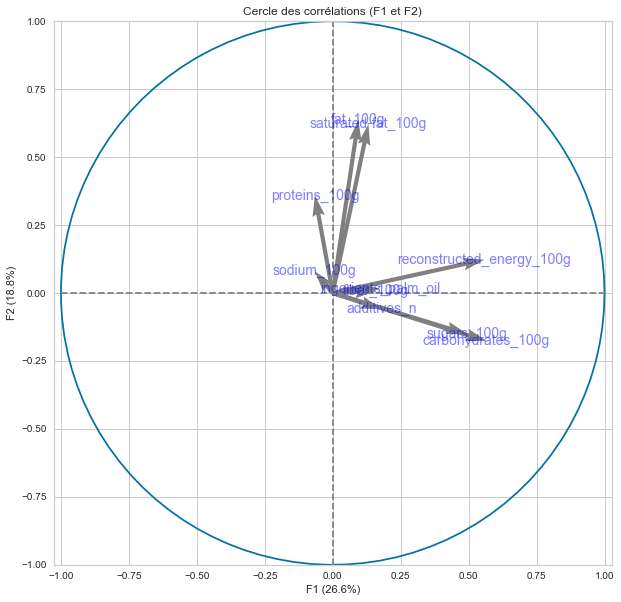

In [1189]:
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

La première composante explique 26,55% de la variance et la 2nde composante explique 18.75% de la variance

Les 2 composantes expliquent donc un total de 45.3% de la variance.

In [1190]:
# vérification que les 831803 produits sont dans un espace à 2 dimensions
X_projected=pca.transform(X_scaled)
print(X_projected.shape)

(829942, 2)


# 4) Apprentissage non-supervisé 

## a) Algorithme du K-MEANS

In [2]:
from sklearn.cluster import KMeans
from yellowbrick.style import set_palette
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score

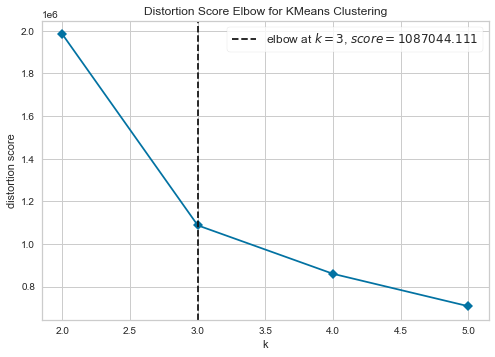

In [1192]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,6), metric='distortion', timings=False)

visualizer.fit(pca_components) # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

In [1193]:
print("Nombre de produits dans le Cluster 0 :", df_France["product_name"].loc[df_France["Clusters"] == 0].count())
print("Nombre de produits dans le Cluster 1 :", df_France["product_name"].loc[df_France["Clusters"] == 1].count())
print("Nombre de produits dans le Cluster 2 :", df_France["product_name"].loc[df_France["Clusters"] == 2].count())

Nombre de produits dans le Cluster 0 : 477701
Nombre de produits dans le Cluster 1 : 232620
Nombre de produits dans le Cluster 2 : 119621


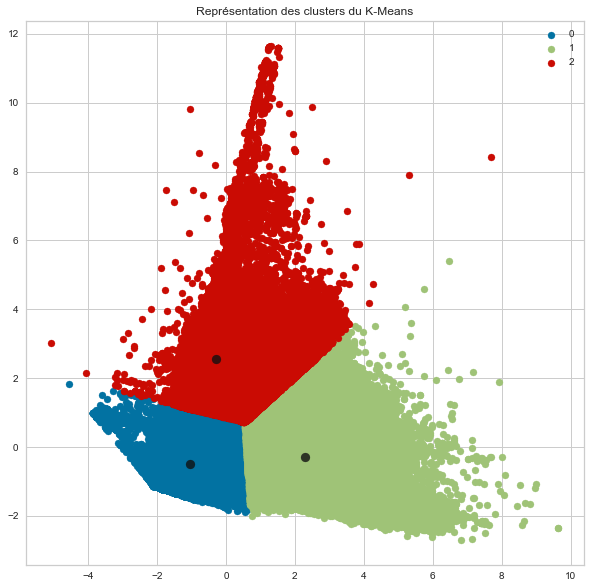

In [1194]:
km = KMeans(n_clusters=3, random_state=50)

#Prédiction
label = km.fit_predict(pca_components)
 
centroids = km.cluster_centers_
u_labels = np.unique(label)

#Représentation graphique:

plt.figure(figsize=(10,10))
for i in u_labels:
    plt.scatter(pca_components[label == i , 0] , pca_components[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 0.8, color = 'k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.savefig("representation_kmeans.png")
plt.show()

In [ ]:
print("Score de Davies-Bouldin :", davies_bouldin_score(pca_components, labels=km.labels_).round(3))

In [ ]:
print("Score de silhouette :", silhouette_score(pca_components,labels=km.labels_).round(3))

In [1195]:
# Création pipeline
from sklearn.pipeline import Pipeline
model = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2)), ('kmeans', KMeans(n_clusters=3))])
model.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('kmeans', KMeans(n_clusters=3))])

In [1196]:
import joblib
# Sauvegarde du modèle avec PCA
joblib.dump(model, 'NutriClass_model.pkl')

['NutriClass_model.pkl']

### Analyse des clusters :

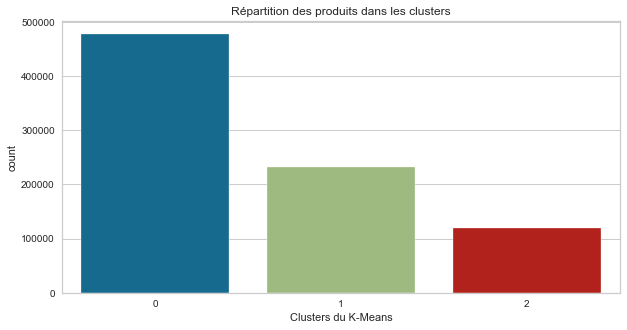

In [1197]:
# Répartition des produits dans les clusters
plt.figure(figsize=(10,5))
sns.countplot(x="Clusters", data=df_France)
plt.xlabel("Clusters du K-Means")
plt.title("Répartition des produits dans les clusters")
plt.savefig("repartition_produits_kmeans.png")
plt.show()

In [1198]:
# caractéristiques moyennes des Groupes de clusters 
clusters_groups = df_France.groupby("Clusters").mean().round(3)
clusters_groups.drop(['ingredients_from_palm_oil_n', "ingredients_that_may_be_from_palm_oil_n", "nova_group"], axis=1, inplace=True)
clusters_groups

,additives_n,nutriscore_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,reconstructed_energy_100g,ingerients_palm_oil
Clusters,,,,,,,,,,,
0,1.019,7.833,5.914,1.693,11.481,4.136,1.673,6.788,0.448,194.187,0.013
1,1.643,11.416,12.728,5.293,61.294,32.051,2.878,6.496,0.264,683.137,0.154
2,0.860,12.870,39.167,15.242,8.455,3.940,1.881,17.894,0.710,404.454,0.022


#### Cluster 0 : Sains
#### Cluster 1 : Caloriques sucré
#### Cluster 2 : Caloriques gras 

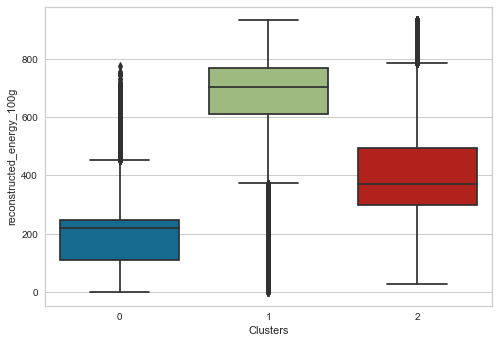

In [1199]:
sns.boxplot(x="Clusters", y="reconstructed_energy_100g", data=df_France)
plt.show()

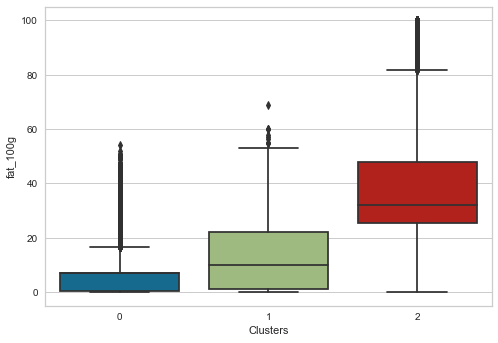

In [1200]:
sns.boxplot(x="Clusters", y="fat_100g", data=df_France)
plt.show()

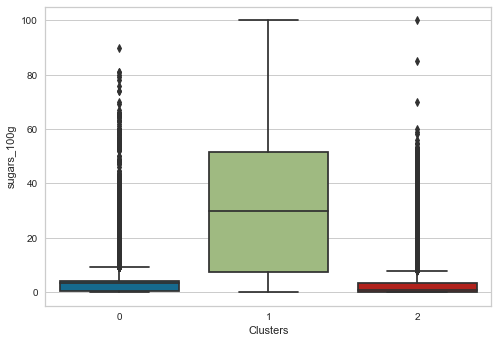

In [1201]:
sns.boxplot(x="Clusters", y="sugars_100g", data=df_France)
plt.show()

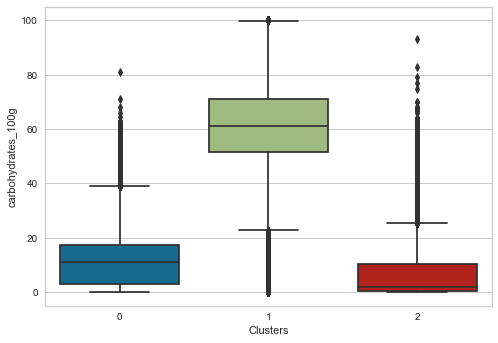

In [1202]:
sns.boxplot(x="Clusters", y="carbohydrates_100g", data=df_France)
plt.show()

### Nous pouvons confirmer à travers ces 4 graphiques que : 
Le cluster 0 est sains

Le cluster 1 est calorique et sucré

Le cluster 2 est calorique et gras

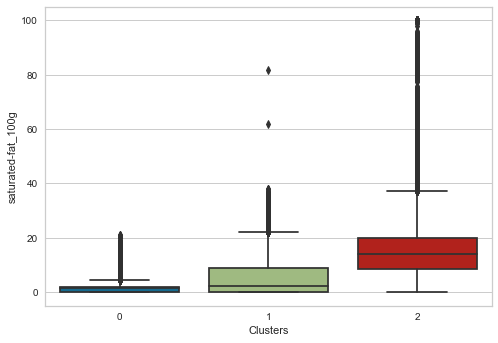

In [1203]:
sns.boxplot(x="Clusters", y="saturated-fat_100g", data=df_France)
plt.show()

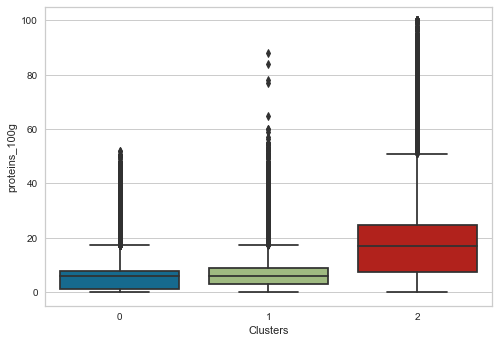

In [1204]:
sns.boxplot(x="Clusters", y="proteins_100g", data=df_France)
plt.show()

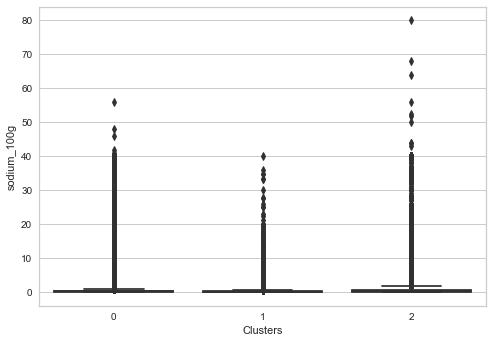

In [1205]:
sns.boxplot(x="Clusters", y="sodium_100g", data=df_France)
plt.show()

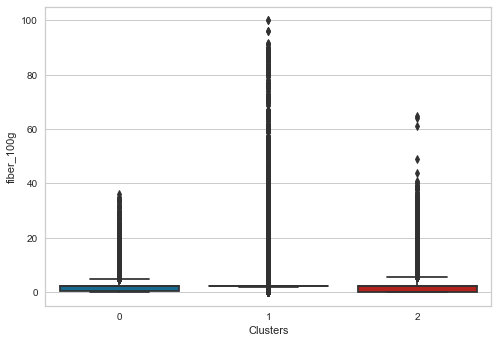

In [1206]:
sns.boxplot(x="Clusters", y="fiber_100g", data=df_France)
plt.show()

In [1207]:
df["ingerients_palm_oil"] = df["ingredients_from_palm_oil_n"] + df["ingredients_that_may_be_from_palm_oil_n"]

# Prédiction du cluster d'appartenance d'un produit

In [1208]:
# Test de prédiction par lecture du code a Barres

#### Produits sains ##########
produit1 = df_France.loc[df_France['code'] == "3083681085860"]   # Pois Chiches cuits dans très peu de jus - Bonduelle - 265 g
produit2 = df_France.loc[df_France['code'] == "3083680001717"]   # Haricots blancs préparés - Bonduelle - 800 g
produit3 = df_France.loc[df_France['code'] == "5413458017578"]   # Filets de poulet - Sans marque - 1,000 kg
produit4 = df_France.loc[df_France['code'] == "3180840005445"]   # Dattes Deglet Nour - U - 500 g
produit5 = df_France.loc[df_France['code'] == "3228857000166"]   # Harrys pain de mie 100% mie complet sans croute - 500 g
produit6 = df_France.loc[df_France['code'] == "0292471016998"]   # Bifteck - Charal - 118 g  

#### Prduits calorqiues & gras ##########
produit7 = df_France.loc[df_France['code'] == "3451790988677"]   # Le Beurre Tendre barquette doux - Elle & Vire - 250 g 
produit8 = df_France.loc[df_France['code'] == "8719200058071"]   # Margarine 
produit9 = df_France.loc[df_France['code'] == "3155251205500"]   # Beurre Président
produit10 = df_France.loc[df_France['code'] == "3046920022606"]  # Chocolat Lindt
produit11 = df_France.loc[df_France['code'] == "8410179012230"]  # Huile d'olive
produit12 = df_France.loc[df_France['code'] == "3560070168651"]  # Cheddar


#### Prduits caloriques & Sucrés ##########
produit13 = df_France.loc[df_France['code'] == "3017620425035"]  # Nutella 
produit14 = df_France.loc[df_France['code'] == "8000500003787"]  # Ferrero Rocher
produit15 = df_France.loc[df_France['code'] == "3088542004264"]  # gelée royale
produit16 = df_France.loc[df_France['code'] == "3165432640006"]  # Sucre glace
produit17 = df_France.loc[df_France['code'] == "8000500290750"]  # Barre goûter Kinder
produit18 = df_France.loc[df_France['code'] == "7613035607729"]  # Lait en poudre GUIGOZ

#### Caloriques et trop sucrés ############
produit19 = df_France.loc[df_France['code'] == "000000000262"]  # Confiture de lait
produit20 = df_France.loc[df_France['code'] == "0000000004299"]  # Crêpes au Kamok

In [1209]:
product_name_1= produit1.product_name
product_name_2= produit2.product_name
product_name_3= produit3.product_name
product_name_4= produit4.product_name
product_name_5= produit5.product_name
product_name_6= produit6.product_name
product_name_7= produit7.product_name
product_name_8= produit8.product_name
product_name_9= produit9.product_name
product_name_10= produit10.product_name
product_name_11= produit11.product_name
product_name_12= produit12.product_name
product_name_13= produit13.product_name
product_name_14= produit14.product_name
product_name_15= produit15.product_name
product_name_16= produit16.product_name
product_name_17= produit17.product_name
product_name_18= produit18.product_name
product_name_19= produit19.product_name
product_name_20= produit20.product_name

#### Cluster 0 : Sains
#### Cluster 1 : Caloriques sucré
#### Cluster 2 : Calorique gras 

In [1210]:
prod_sains= df_France.loc[(df_France['code'] == "3083681085860") | (df_France['code'] == "3083680001717") | (df_France['code'] == "5413458017578") | (df_France['code'] == "3180840005445") | (df_France['code'] == "3228857000166")| (df_France['code'] == "0292471016998")]
prod_sains

,code,product_name,countries,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,reconstructed_energy_100g,ingerients_palm_oil,Clusters
338140,0292471016998,Bifteck,France,0.0,0.0,0.0,-4.0,A,4.0,Fish Meat Eggs,...,2.3,0.8,0.0,0.0,0.0,23.0,0.068,223.5830,0.0,0
710145,3083680001717,Haricots blancs préparés,France,0.0,0.0,0.0,-7.0,A,4.0,Cereals and potatoes,...,0.6,0.1,12.3,0.7,6.3,7.2,0.180,184.0785,0.0,0
711166,3083681085860,Pois Chiches cuits dans très peu de jus,France,0.0,0.0,0.0,-5.0,A,3.0,Cereals and potatoes,...,2.2,0.2,14.7,0.5,7.7,6.4,0.240,205.4785,0.0,0
734593,3180840005445,"Dattes Deglet Nour, Maitre Prunille",France,0.0,0.0,0.0,1.0,B,1.0,Fruits and vegetables,...,0.2,0.1,68.0,68.0,7.3,3.3,0.040,664.9715,0.0,1
749757,3228857000166,Harrys pain de mie 100% mie complet sans croute,France,0.0,0.0,0.0,-2.0,A,4.0,Cereals and potatoes,...,4.3,0.4,39.7,4.3,7.1,7.2,0.436,454.3315,0.0,0
1360648,5413458017578,Filets de poulet,France,0.0,0.0,0.0,-4.0,A,1.0,Fish Meat Eggs,...,2.4,0.9,0.5,0.5,0.0,22.0,0.080,219.3315,0.0,0


### Les produits sont classés dans le bon cluster 0 sauf les dattes qu'il considère comme un produit calorique et sucré

#### Cluster 0 : Sains
#### Cluster 1 : Caloriques sucré
#### Cluster 2 : Calorique gras 

In [1211]:
prod_Energetiques_Gras= df_France.loc[(df_France['code'] == "3451790988677") | (df_France['code'] == "8719200058071") | (df_France['code'] == "3155251205500") | (df_France['code'] == "3046920022606") | (df_France['code'] == "8410179012230")| (df_France['code'] == "3560070168651")]
prod_Energetiques_Gras

,code,product_name,countries,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,reconstructed_energy_100g,ingerients_palm_oil,Clusters
702884,3046920022606,Lindt excellence,France,0.0,0.0,0.0,27.0,E,3.0,Sugary snacks,...,46.0,28.0,19.0,11.0,4.65,12.0,0.800000,475.5250,0.0,2
723460,3155251205500,Beurre doux gastronomique,France,0.0,0.0,0.0,19.0,E,3.0,unknown,...,82.0,57.0,1.0,1.0,2.20,0.7,0.000012,348.7555,0.0,2
907657,3451790988677,Le Beurre Tendre barquette doux,France,0.0,0.0,0.0,19.0,E,2.0,Fat and sauces,...,82.0,57.0,0.8,0.8,0.00,0.7,0.020000,346.8925,0.0,2
942927,3560070168651,Cheddar - Tranches pour burgers,France,1.0,0.0,0.0,17.0,D,4.0,Milk and dairy products,...,35.0,23.0,0.5,0.5,0.00,24.0,0.720000,370.3175,0.0,2
1675649,8410179012230,Huile d'Olive Vierge Extra Bio,France,0.0,0.0,0.0,7.0,C,2.0,Fat and sauces,...,100.0,16.0,0.0,0.0,0.00,0.0,0.000000,406.0000,0.0,2
1878580,8719200058071,Planta fin tartine et cuisson,France,2.0,1.0,0.0,13.0,D,4.0,Salty snacks,...,60.0,24.0,0.0,0.0,2.20,0.0,0.128000,243.6000,1.0,2


### Les produits sont classés dans le bon cluster 2 (Gras & calorique)

#### Cluster 0 : Sains
#### Cluster 1 : Caloriques sucré
#### Cluster 2 : Calorique gras 

In [1212]:
prod_Energetiques_sucree= df_France.loc[(df_France['code'] == "3017620425035") | (df_France['code'] == "8000500003787") | (df_France['code'] == "3088542004264") | (df_France['code'] == "3165432640006") | (df_France['code'] == "8000500290750")| (df_France['code'] == "7613035607729")]
prod_Energetiques_sucree

,code,product_name,countries,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,reconstructed_energy_100g,ingerients_palm_oil,Clusters
689028,3017620425035,Nutella,France,1.0,1.0,0.0,26.0,E,4.0,Sugary snacks,...,30.9,10.6,57.5,56.3,0.0,6.3,0.0428,719.7510,1.0,1
711888,3088542004264,Gelée royale,France,0.0,0.0,0.0,14.0,D,3.0,Sugary snacks,...,0.5,0.5,82.0,64.0,1.0,0.7,0.0000,772.3805,0.0,1
725880,3165432640006,Sucre glace,France,0.0,0.0,0.0,15.0,D,2.0,Sugary snacks,...,0.0,0.0,100.0,98.0,0.0,0.0,0.0000,931.5000,0.0,1
1475643,7613035607729,GUIGOZ OPTIPRO Lait Infantile 900g 1er âge dès...,France,3.0,0.0,1.0,10.0,NaN,4.0,unknown,...,27.6,6.5,57.7,57.7,0.8,9.6,0.1650,738.9555,1.0,1
1526943,8000500003787,"Ferrero rocher, whole hazelnut in milk chocola...",France,2.0,0.0,0.0,25.0,E,4.0,Sugary snacks,...,42.7,14.1,44.4,39.9,1.0,8.2,0.0612,663.3310,0.0,1
1527493,8000500290750,Kinder pingui gouter frais genoise avec chocol...,France,2.0,1.0,1.0,23.0,E,4.0,Sugary snacks,...,29.7,20.0,37.8,33.1,2.3,7.0,0.1016,537.8940,2.0,1


In [1213]:
prod_Energetiques_trop_sucree= df_France.loc[(df_France['code'] == "000000000262") | (df_France['code'] == "0000000004299")]
prod_Energetiques_trop_sucree

,code,product_name,countries,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,reconstructed_energy_100g,ingerients_palm_oil,Clusters
43,000000000262,Confiture de lait,France,2.0,0.0,0.0,14.0,NaN,4.0,Sugary snacks,...,0.5,0.18,63.64,53.0,1.0,0.82,0.02,602.4749,0.0,1
53,0000000004299,Crêpes au Kamok,France,1.0,0.0,0.0,10.0,NaN,4.0,unknown,...,5.7,3.00,58.00,38.0,2.2,3.40,0.24,595.0830,0.0,1


###  Les produits sont classés dans le bon cluster 1 ( Sucré et calorique)

In [1214]:
produit1 = produit1[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit2 = produit2[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit3 = produit3[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit4 = produit4[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit5 = produit5[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit6 = produit6[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]

In [1215]:
# Chargement du model de prédiction :
NutriClass = joblib.load('NutriClass_model.pkl')

In [1216]:
# Prédicition de la classe du produit 1  
print('Cluster:', NutriClass.predict(produit1))
print('Produit:' , product_name_1) 

print('Cluster:', NutriClass.predict(produit2))
print('Produit:' , product_name_2) 

print('Cluster:', NutriClass.predict(produit3))
print('Produit:' , product_name_3) 

print('Cluster:', NutriClass.predict(produit4))
print('Produit:' , product_name_4) 

print('Cluster:', NutriClass.predict(produit5))
print('Produit:' , product_name_5) 

print('Cluster:', NutriClass.predict(produit6))
print('Produit:' , product_name_6) 

Cluster: [0]
Produit: 711166    Pois Chiches cuits dans très peu de jus
Name: product_name, dtype: object
Cluster: [0]
Produit: 710145    Haricots blancs préparés
Name: product_name, dtype: object
Cluster: [0]
Produit: 1360648    Filets de poulet
Name: product_name, dtype: object
Cluster: [1]
Produit: 734593    Dattes Deglet Nour, Maitre Prunille
Name: product_name, dtype: object
Cluster: [0]
Produit: 749757    Harrys pain de mie 100% mie complet sans croute
Name: product_name, dtype: object
Cluster: [0]
Produit: 338140    Bifteck
Name: product_name, dtype: object


#### Cluster 0 : Sains
#### Cluster 1 : Caloriques sucré
#### Cluster 2 : Calorique gras  

##  L'algorithme a classé les produits suivants dans un cluster sains (cluster [0] ): 

Pois Chiches cuits dans très peu de jus

Haricots blancs préparés

Filets de poulet

Harrys pain de mie 100% mie complet sans croute

Bifteck

On remarque que les dattes ont été classées dans le cluster [1] , cluster sucré et calorique, ce qui semble logique car ces derniers peuvent soit appartenir à un cluster sains, soit appartenir à un cluster calorique & sucré. Cela dépends de leur variété. 

## L'algorithme fonctionne donc très bien. 

In [1217]:
produit7 = produit7[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit8 = produit8[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit9 = produit9[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit10 = produit10[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit11 = produit11[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit12 = produit12[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]

In [1218]:
print('Cluster:', NutriClass.predict(produit7))
print('Produit:' , product_name_7) 

print('Cluster:', NutriClass.predict(produit8))
print('Produit:' , product_name_8) 

print('Cluster:', NutriClass.predict(produit9))
print('Produit:' , product_name_9) 

print('Cluster:', NutriClass.predict(produit10))
print('Produit:' , product_name_10) 

print('Cluster:', NutriClass.predict(produit11))
print('Produit:' , product_name_11) 

print('Cluster:', NutriClass.predict(produit12))
print('Produit:' , product_name_12) 

Cluster: [2]
Produit: 907657    Le Beurre Tendre barquette doux
Name: product_name, dtype: object
Cluster: [2]
Produit: 1878580    Planta fin tartine et cuisson
Name: product_name, dtype: object
Cluster: [2]
Produit: 723460    Beurre doux gastronomique
Name: product_name, dtype: object
Cluster: [2]
Produit: 702884    Lindt excellence
Name: product_name, dtype: object
Cluster: [2]
Produit: 1675649    Huile d'Olive Vierge Extra Bio
Name: product_name, dtype: object
Cluster: [2]
Produit: 942927    Cheddar - Tranches pour burgers
Name: product_name, dtype: object


#### Cluster 0 : Sains
#### Cluster 1 : Caloriques sucré
#### Cluster 2 : Calorique gras 

###  L'algorithme a classé les produits suivants dans un cluster calorique & Gras (cluster [2]): 

Le Beurre Tendre barquette doux

Planta fin tartine et cuisson

Beurre doux gastronomique

Lindt excellence

Huile d'Olive Vierge Extra Bio

Cheddar - Tranches pour burgers

### L'algorithme fonctionne donc très bien. 

In [1219]:
produit13 = produit13[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit14 = produit14[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit15 = produit15[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit16 = produit16[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit17 = produit17[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit18 = produit18[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit19 = produit19[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]
produit20 = produit20[['additives_n','reconstructed_energy_100g','ingerients_palm_oil','fat_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','carbohydrates_100g']]

In [1226]:
print('Cluster:', NutriClass.predict(produit13))
print('Produit:' , product_name_13) 

print('Cluster:', NutriClass.predict(produit14))
print('Produit:' , product_name_14) 

print('Cluster:', NutriClass.predict(produit15))
print('Produit:' , product_name_15) 

print('Cluster:', NutriClass.predict(produit16))
print('Produit:' , product_name_16) 

print('Cluster:', NutriClass.predict(produit17))
print('Produit:' , product_name_17) 

print('Cluster:', NutriClass.predict(produit18))
print('Produit:' , product_name_18) 

print('Cluster:', NutriClass.predict(produit19))
print('Produit:' , product_name_19) 

print('Cluster:', NutriClass.predict(produit20))
print('Produit:' , product_name_20) 

Cluster: [1]
Produit: 689028    Nutella
Name: product_name, dtype: object
Cluster: [1]
Produit: 1526943    Ferrero rocher, whole hazelnut in milk chocola...
Name: product_name, dtype: object
Cluster: [1]
Produit: 711888    Gelée royale
Name: product_name, dtype: object
Cluster: [1]
Produit: 725880    Sucre glace
Name: product_name, dtype: object
Cluster: [1]
Produit: 1527493    Kinder pingui gouter frais genoise avec chocol...
Name: product_name, dtype: object
Cluster: [1]
Produit: 1475643    GUIGOZ OPTIPRO Lait Infantile 900g 1er âge dès...
Name: product_name, dtype: object
Cluster: [1]
Produit: 43    Confiture de lait
Name: product_name, dtype: object
Cluster: [1]
Produit: 53    Crêpes au Kamok
Name: product_name, dtype: object


#### Cluster 0 : Sains
#### Cluster 1 : Caloriques sucré
#### Cluster 2 : Calorique gras 

###  L'algorithme a classé les produits suivants dans un cluster calorique & sucré (cluster [1] ): 

Nutella

Ferrero rocher, whole hazelnut in milk chocola...

Gelée royale

Sucre glace

Kinder pingui gouter frais genoise avec chocol...

GUIGOZ OPTIPRO Lait Infantile 900g 1er âge dès...

Confiture de lait

Crêpes au Kamok

### L'algorithme fonctionne donc très bien. 

In [1224]:
clusters_groups

,additives_n,nutriscore_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,reconstructed_energy_100g,ingerients_palm_oil
Clusters,,,,,,,,,,,
0,1.019,7.833,5.914,1.693,11.481,4.136,1.673,6.788,0.448,194.187,0.013
1,1.643,11.416,12.728,5.293,61.294,32.051,2.878,6.496,0.264,683.137,0.154
2,0.860,12.870,39.167,15.242,8.455,3.940,1.881,17.894,0.710,404.454,0.022
